In [137]:
import ccxt
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')

# remove matplotlib warnings
import warnings
warnings.filterwarnings("ignore")
#%matplotlib inline

In [138]:
# Download all btc 1h data
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1h'
since = exchange.parse8601('2020-08-17T00:00:00Z')
all_data = []
while since < exchange.milliseconds():
    ohlcvs = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(ohlcvs) > 0:
        since = ohlcvs[-1][0] + 1
        all_data += ohlcvs
    else:
        break
df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df

,open,high,low,close,volume
timestamp,,,,,
2020-08-17 00:00:00,11910.99,11933.15,11801.00,11845.31,2488.440228
2020-08-17 01:00:00,11845.31,11849.60,11781.25,11843.63,1307.139321
2020-08-17 02:00:00,11843.68,11868.00,11769.78,11860.27,1539.784049
2020-08-17 03:00:00,11860.26,11872.82,11837.48,11844.71,1295.923737
2020-08-17 04:00:00,11844.72,11858.91,11802.35,11809.38,1454.171816
...,...,...,...,...,...
2024-04-10 19:00:00,69314.33,70098.89,69219.14,70083.99,2385.515750
2024-04-10 20:00:00,70084.00,70136.00,69740.00,69812.01,1217.117630
2024-04-10 21:00:00,69812.01,70036.81,69581.03,70017.00,1101.471260


In [139]:
df_train, df_test = train_test_split(df, test_size=0.4, shuffle=False)
df_train

,open,high,low,close,volume
timestamp,,,,,
2020-08-17 00:00:00,11910.99,11933.15,11801.00,11845.31,2488.440228
2020-08-17 01:00:00,11845.31,11849.60,11781.25,11843.63,1307.139321
2020-08-17 02:00:00,11843.68,11868.00,11769.78,11860.27,1539.784049
2020-08-17 03:00:00,11860.26,11872.82,11837.48,11844.71,1295.923737
2020-08-17 04:00:00,11844.72,11858.91,11802.35,11809.38,1454.171816
...,...,...,...,...,...
2022-10-25 21:00:00,20188.99,20270.00,20100.00,20232.30,9360.635310
2022-10-25 22:00:00,20231.00,20235.41,19981.12,20063.30,9074.953460
2022-10-25 23:00:00,20063.30,20135.35,20039.29,20080.07,8544.856760


In [140]:
# Pattern schema
# O[0] < L[1] & C[0] < H[1]
# O : Open, H : High, L : Low, C : Close
# 0 : Current, 1 : 1 Candle ago, 2 : 2 Candles ago, etc
# & is a comparison operator
# Pattern size: determine how many comparison operators are in the pattern
# Number of candles: determine how many candles to look back

In [141]:
mapping = {
    'O': 'open',
    'H': 'high',
    'L': 'low',
    'C': 'close'
}

class Rule:
    def __init__(self, look_back):
        self.left_member = (None, None)
        self.right_member = (None, None)
        self.operator = None
        self.look_back = look_back
    
    def __str__(self):
        return f'{self.left_member[0]}[{self.left_member[1]}] {self.operator} {self.right_member[0]}[{self.right_member[1]}]'

    def init_random(self):
        self.left_member = (np.random.choice(['O', 'H', 'L', 'C']), np.random.randint(0, self.look_back))
        self.right_member = (np.random.choice(['O', 'H', 'L', 'C']), np.random.randint(0, self.look_back))
        self.operator = np.random.choice(['<', '>'])
        
        # check for invalid rules
        if self.left_member[1] == self.right_member[1]:
            self.init_random()
        
    def evaluate(self, df):
        left_data = df[mapping[self.left_member[0]]].shift(self.left_member[1])
        right_data = df[mapping[self.right_member[0]]].shift(self.right_member[1])
        if self.operator == '<':
            result = left_data < right_data
        elif self.operator == '>':
            result = left_data > right_data
        return result


In [142]:
class Pattern:
    def __init__(self, pattern_size, look_back):
        self.pattern_size = pattern_size
        self.look_back = look_back
        self.fitness = 0
        self.rules = []
        
    def __str__(self):
        return ' & '.join([str(rule) for rule in self.rules])
    
    def init_random_patterns(self):
        for i in range(self.pattern_size):
            rule = Rule(self.look_back)
            rule.init_random()
            self.rules.append(rule)
        
        # check for invalid patterns
        if len(set([str(rule) for rule in self.rules])) != len(self.rules):
            self.rules = []
            self.init_random_patterns()
        
        # check for invalid patterns (e.g. O[0] < C[0] & C[0] > O[0]) you can not compare the same candle
        for i in range(self.pattern_size):
            if self.rules[i].left_member[1] == self.rules[i].right_member[1]:
                self.rules = []
                self.init_random_patterns()
                break
    
    def evaluate_pattern(self, df):
        results = [rule.evaluate(df) for rule in self.rules]
        result = results[0]
        for i in range(1, self.pattern_size):
            result = result & results[i]
        return result

In [143]:
class Population:
    def __init__(self,
                 pattern_size,
                 look_back,
                 population_size,
                 top_k,
                 mutation_rate=0.1,
                 crossover_rate=0.1,
                 n_generations=1000):
        self.pattern_size = pattern_size
        self.look_back = look_back
        self.population_size = population_size
        self.top_k = top_k
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.n_generations = n_generations
        self.best_pattern = None
        self.patterns = []
        self.init_random_population()

    def init_random_population(self):
        self.patterns = []
        for _ in range(self.population_size):
            pattern = Pattern(self.pattern_size, self.look_back)
            pattern.init_random_patterns()
            self.patterns.append(pattern)

    def evaluate_population(self, df):
        for pattern in self.patterns:
            fitness = np.sum(df['close'].pct_change().shift(-1) * pattern.evaluate_pattern(df))
            pattern.fitness = fitness if fitness > 0 else 0
        self.patterns = sorted(self.patterns, key=lambda x: x.fitness, reverse=True)

    def select_by_rolette_wheel(self):
        fitnesses = [pattern.fitness for pattern in self.patterns]
        total_fitness = np.sum(fitnesses)
        if total_fitness == 0:
            selected_indices = np.random.choice(np.arange(self.population_size), size=self.top_k, replace=False)
        else:
            fitnesses = [fitness + 1e-10 for fitness in fitnesses]
            total_fitness += 1e-10 * len(fitnesses)
            probabilities = [fitness / total_fitness for fitness in fitnesses]
            selected_indices = np.random.choice(np.arange(self.population_size), size=self.top_k, p=probabilities, replace=False)
        selected_patterns = [self.patterns[i] for i in selected_indices]
        return selected_patterns

    def crossover(self, best_patterns):
        parent1, parent2 = np.random.choice(best_patterns, size=2, replace=False)
        crossover_point = np.random.randint(0, self.pattern_size)
        child1 = Pattern(self.pattern_size, self.look_back)
        child2 = Pattern(self.pattern_size, self.look_back)
        child1.rules = parent1.rules[:crossover_point] + parent2.rules[crossover_point:]
        child2.rules = parent2.rules[:crossover_point] + parent1.rules[crossover_point:]
        # Validate children they should have valid rules
        if len(set([str(rule) for rule in child1.rules])) != len(child1.rules) or len(set([str(rule) for rule in child2.rules])) != len(child2.rules):
            return self.crossover(best_patterns)
        
        return child1, child2

    def mutate(self, pattern):
        for rule in pattern.rules:
            if np.random.rand() < self.mutation_rate:
                rule.init_random()

    def evolve(self, df):
        for i in range(self.n_generations):
            self.evaluate_population(df)
            best_patterns = self.select_by_rolette_wheel()
            new_patterns = [copy.deepcopy(pattern) for pattern in best_patterns]
            max_fitness_pattern = max(self.patterns, key=lambda x:x.fitness)
    
            if self.best_pattern is None or max_fitness_pattern.fitness > self.best_pattern.fitness:
                self.best_pattern = copy.deepcopy(max_fitness_pattern)
    
            if self.best_pattern is not None:
                new_patterns.append(copy.deepcopy(self.best_pattern))
    
            if np.random.rand() < self.crossover_rate:
                while len(new_patterns) < self.population_size:
                    child1, child2 = self.crossover(new_patterns)
                    new_patterns += [child1, child2]
                new_patterns = new_patterns[:self.population_size]
    
            for pattern in new_patterns:
                self.mutate(pattern)
    
            if len(new_patterns) < self.population_size:
                for _ in range(self.population_size - len(new_patterns)):
                    new_pattern = Pattern(self.pattern_size, self.look_back)
                    new_pattern.init_random_patterns()
                    new_patterns.append(new_pattern)
            elif len(new_patterns) > self.population_size:
                new_patterns = new_patterns[:self.population_size]
    
            self.patterns = new_patterns
            print(f'Generation {i+1} of {self.n_generations}, best fitness: {self.best_pattern.fitness}', end='\r')    
            
        return self.best_pattern

In [144]:
def visualize_pnl(df, pattern, train_index):
    signals = pattern.evaluate_pattern(df)
    df['pnl'] = df['close'].pct_change().shift(-1) * signals
    df['pnl'] = df['pnl'].cumsum()
    plt.figure(figsize=(10, 5))
    plt.plot(df['pnl'].iloc[train_index:], label='PnL Train', c='b')
    plt.plot(df['pnl'].iloc[:train_index], label='PnL Test', c='g')
    plt.show()

In [157]:
def visualize_pattern(df, pattern):
    fig, axs = plt.subplots(6, 6, figsize=(20, 20))
    # fig.tight_layout(pad=6.0)

    # Obtén los índices donde el patrón se cumple
    pattern_indices = pattern.evaluate_pattern(df)

    # Encuentra las marcas de tiempo donde el patrón es verdadero
    pattern_times = df.index[pattern_indices]

    # Calcula cuántas observaciones mostrar (máximo 16)
    num_observations = min(len(pattern_times), 36)

    # Selecciona muestras distribuidas uniformemente a lo largo del conjunto de índices donde el patrón se cumple
    selected_indices = np.round(np.linspace(1, len(pattern_times) - 1, num=num_observations)).astype(int)
    selected_times = pattern_times[selected_indices]

    for i, ax in enumerate(axs.flatten()):
        if i >= num_observations:
            ax.clear()
            ax.set_axis_off()
            continue

        sample_time = selected_times[i]
        sample_index = df.index.get_loc(sample_time)

        # Construye un DataFrame con los datos necesarios para evaluar el patrón
        pattern_data = df.iloc[max(sample_index - pattern.look_back, 0):sample_index + 1]

        # Asegurarse de que el patrón se cumpla en esta muestra
        if not pattern.evaluate_pattern(pattern_data).iloc[-1]:
            continue

        # Asegurarse de que el índice de inicio no sea negativo
        start_index = max(sample_index - pattern.look_back, 0) + 1  
        end_index = sample_index + 1  # Incluir la vela del patrón

        # Seleccionar el rango de datos basado en índices
        pattern_df = df.iloc[start_index:end_index]

        # Definir colores personalizados para el mercado
        my_market_colors = mpf.make_marketcolors(up='green', down='red', inherit=True)

        # Crear un estilo personalizado basado en 'yahoo' pero con tus colores de mercado
        my_style = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=my_market_colors)

        # Ahora, al llamar a mpf.plot(), usa el estilo personalizado
        mpf.plot(pattern_df, ax=ax, type='candle', datetime_format='%Y-%m-%d', style=my_style)
        
        # remove all labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        
    fig.tight_layout()
    fig.suptitle(str(pattern),  fontsize=16)
    plt.savefig('patterns/' + str(pattern) + '.jpg', dpi=600)
    plt.show()

In [184]:
population = Population(pattern_size=6, look_back=3, population_size=100, top_k=25, mutation_rate=0.35, crossover_rate=0.35, n_generations=400)
population.init_random_population()
best_pattern = population.evolve(df_train)

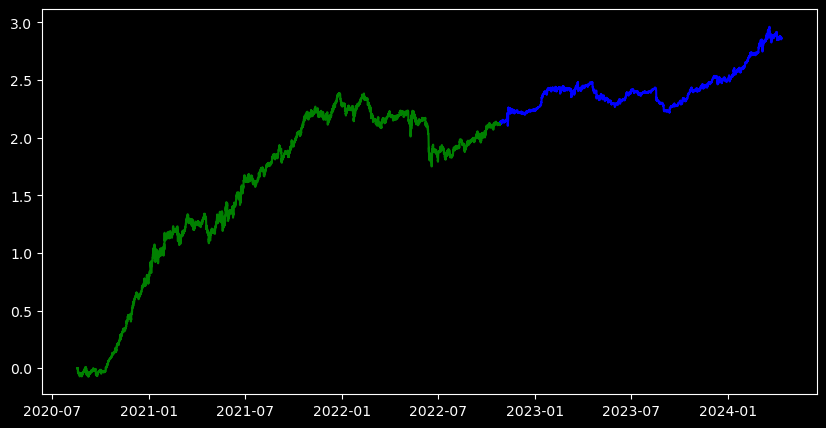

In [185]:
visualize_pnl(df, best_pattern, len(df_train))

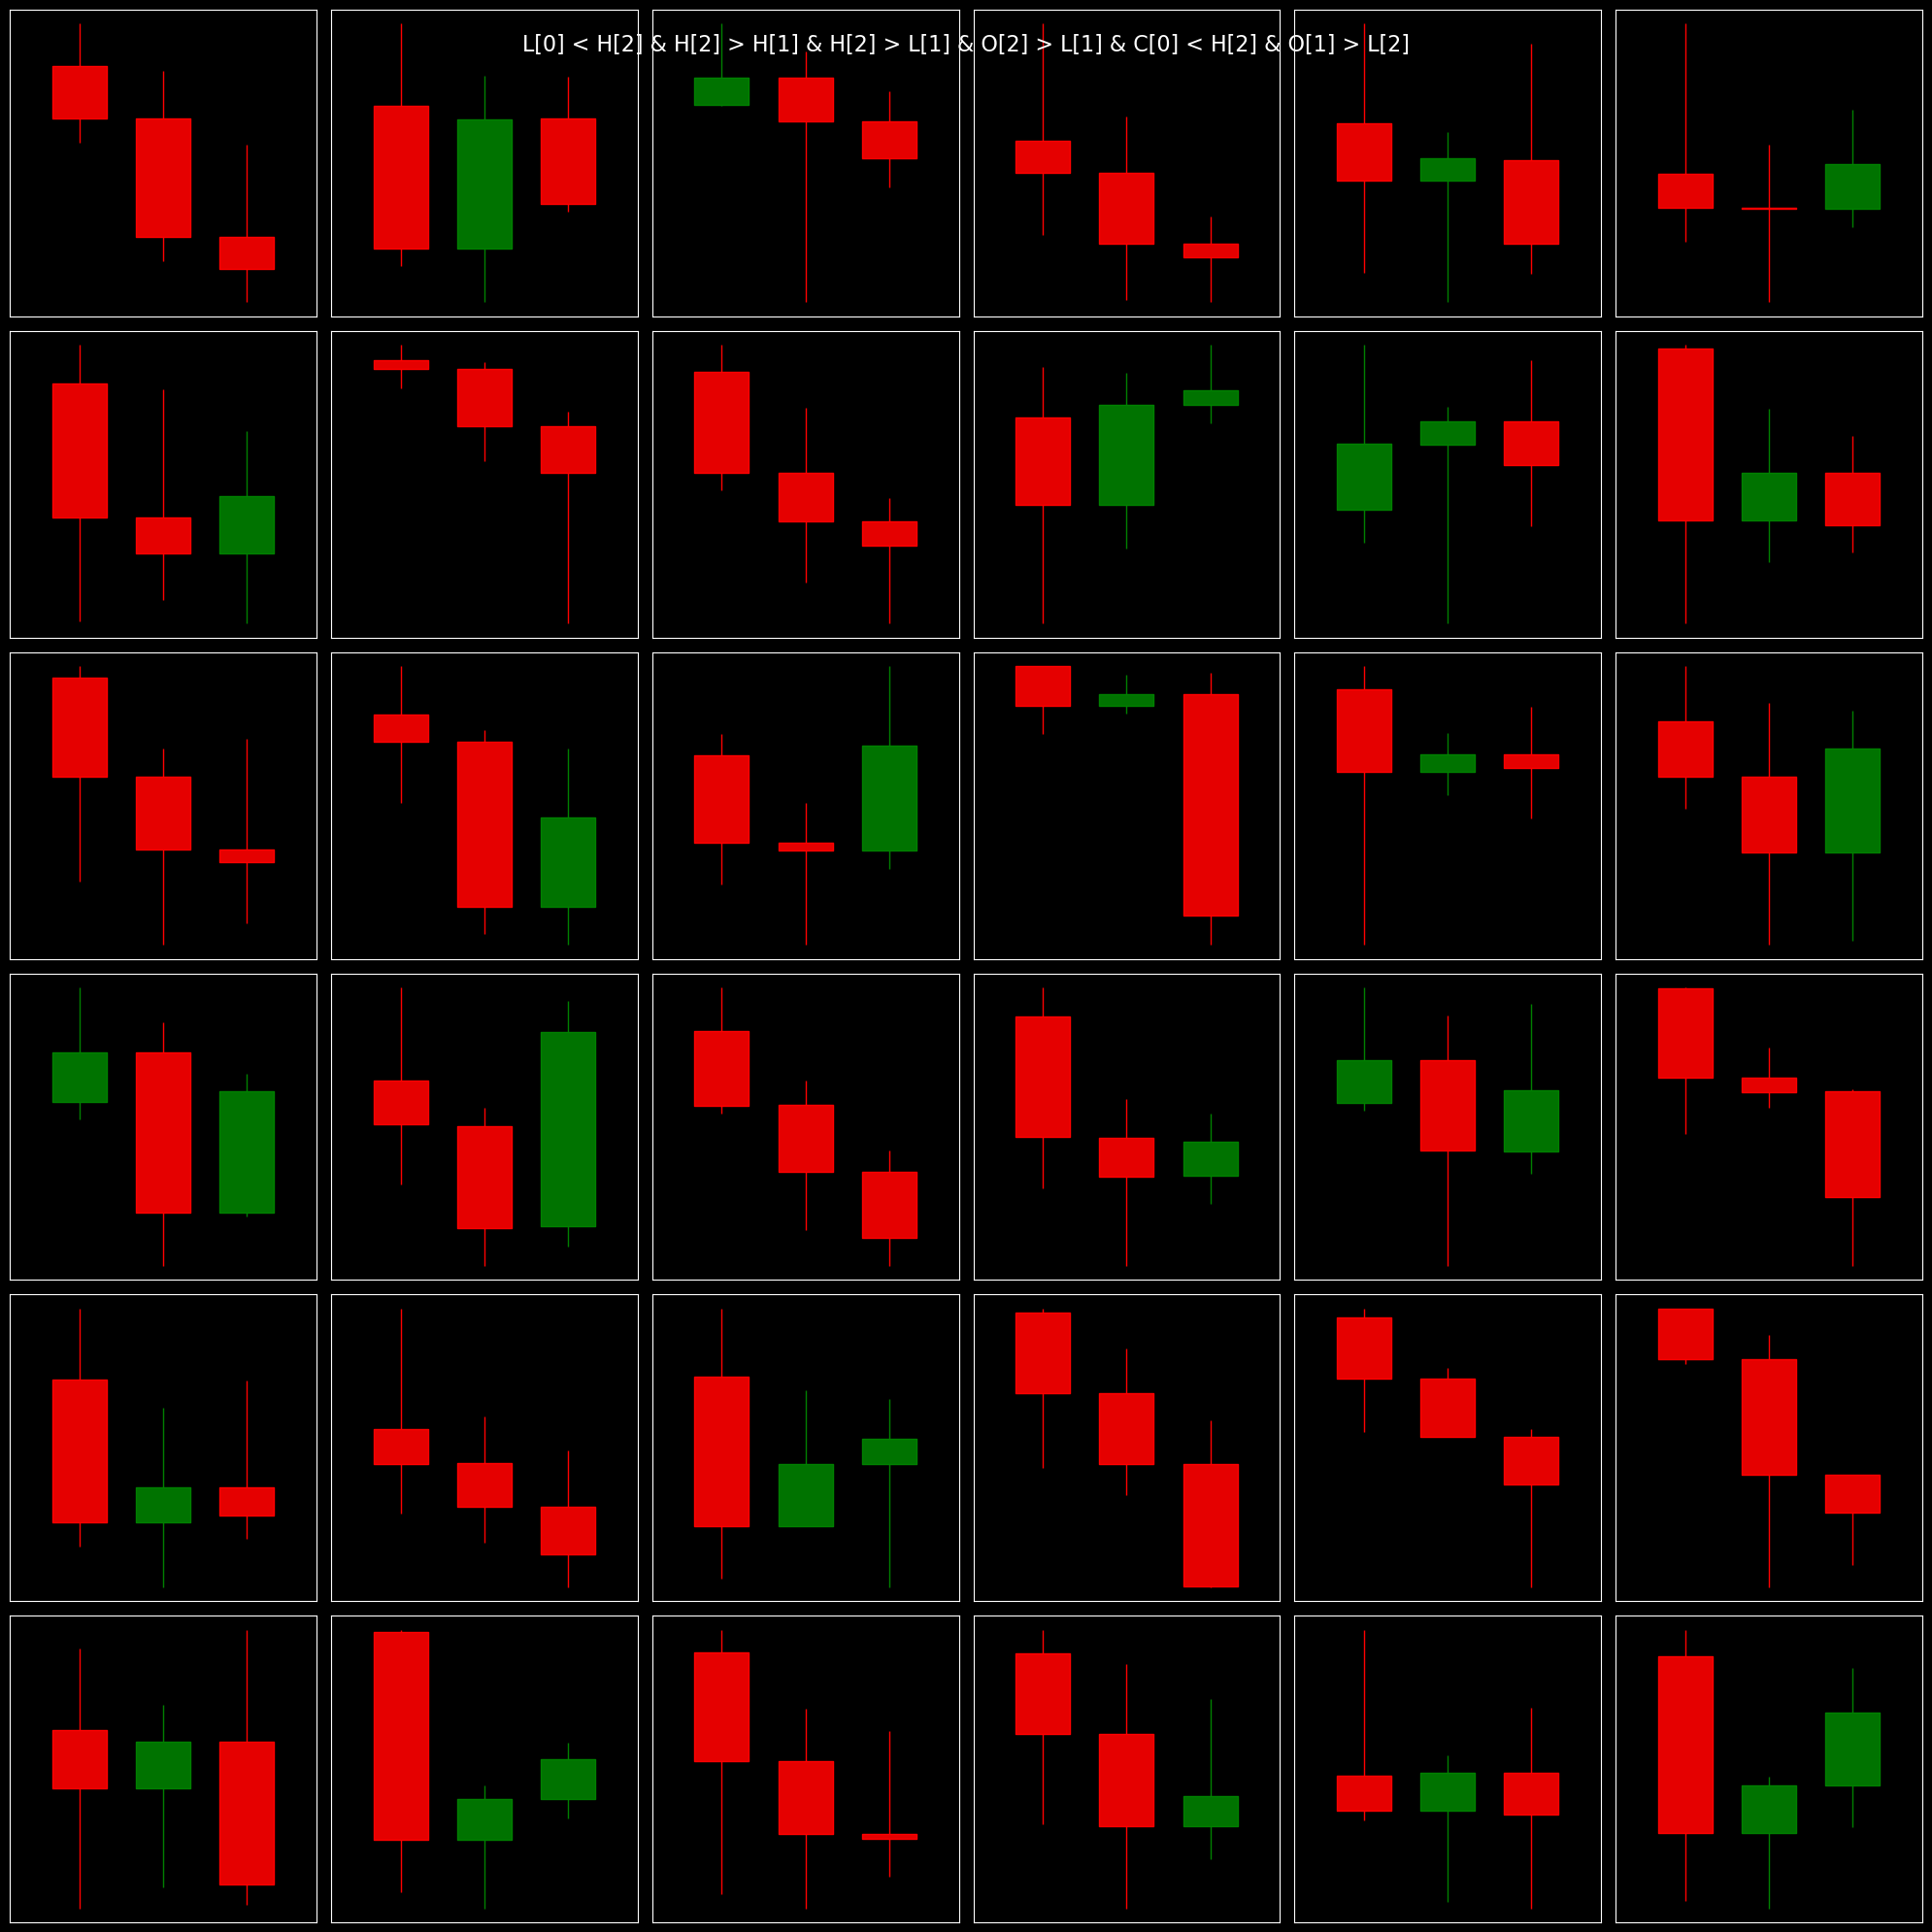

In [186]:
visualize_pattern(df, best_pattern)


In [187]:
print(best_pattern)

L[0] < H[2] & H[2] > H[1] & H[2] > L[1] & O[2] > L[1] & C[0] < H[2] & O[1] > L[2]
